In [ ]:
! pip install langchain-mcp-adapters langgraph "langchain[anthropic]" "langchain[openai]" langgraph-swarm httpx markdownify

## Swarm Researcher Example 

In [35]:
from prompts import planner_prompt, researcher_prompt
from utils import fetch_doc, print_stream

In [36]:
import os
from dotenv import load_dotenv

load_dotenv()
from langchain_openai import AzureChatOpenAI, ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm
from langchain_deepseek import ChatDeepSeek

model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Handoff tools
transfer_to_planner_agent = create_handoff_tool(
    agent_name="planner_agent",
    description="Transfer the user to the planner_agent for clarifying questions related to the user's request.",
)
transfer_to_researcher_agent = create_handoff_tool(
    agent_name="researcher_agent",
    description="Transfer the user to the researcher_agent to perform research and implement the solution to the user's request.",
)

# LLMS.txt
llms_txt = "LangGraph:https://langchain-ai.github.io/langgraph/llms.txt"
num_urls = 3
planner_prompt_formatted = planner_prompt.format(llms_txt=llms_txt, num_urls=num_urls)

In [32]:
model.invoke("what model are you")

AIMessage(content="I am based on OpenAI's GPT-3 model, which is designed for natural language understanding and generation. If you have any questions or need assistance, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 11, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BHFupPZcQAOOT1OaxvuOMCHUfaWiS', 'finish_reason': 'stop', 'logprobs': None}, id='run-cdd59881-9fd1-4cfe-a295-aaab2973dfc6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 37, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [15]:
from langchain_core.tools import tool

@tool
def multiply_numbers(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b
    
model_with_tool = model.bind_tools([multiply_numbers])

result = model_with_tool.invoke("multiply 2 and 4. Do not try to answer on your own via reasoning, try using tools at your disposal such as multiply_numbers")

print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_0_3fe25f6e-3cdc-4001-ab3c-ca02f49e94f1', 'function': {'arguments': '{"a":2,"b":4}', 'name': 'multiply_numbers'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 146, 'total_tokens': 169, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 146}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3d5141a69a_prod0225', 'id': 'e389b2a9-ca11-4bac-b9d0-495e2f0272d1', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-e19cf3ff-bb97-43d0-8183-91a19ce2e469-0' tool_calls=[{'name': 'multiply_numbers', 'args': {'a': 2, 'b': 4}, 'id': 'call_0_3fe25f6e-3cdc-4001-ab3c-ca02f49e94f1', 'type': 'tool_call'}] usage_metadata={'input_tokens': 146, 'output_tokens': 23, 'total_tokens': 169, 'input_token_details': {'cache_read': 0}, 'output_token_details'

In [9]:
result.tool_calls

[]

In [37]:
from langgraph.checkpoint.memory import InMemorySaver

# Planner agent
planner_agent = create_react_agent(
    model,
    prompt=planner_prompt_formatted,
    tools=[fetch_doc, transfer_to_researcher_agent],
    name="planner_agent",
)

# Researcher agent
researcher_agent = create_react_agent(
    model,
    prompt=researcher_prompt,
    tools=[fetch_doc, transfer_to_planner_agent],
    name="researcher_agent",
)

# Swarm
checkpointer = InMemorySaver()
agent_swarm = create_swarm(
    [planner_agent, researcher_agent], default_active_agent="planner_agent"
)
app = agent_swarm.compile(checkpointer=checkpointer)

# Input
request = "Build a nutritional LLM agent for me, which is capable of calorie logging and providing nutritional advice based on users goals and coach guidance"
config = {"configurable": {"thread_id": "1"}}
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": request}]}, config, subgraphs=True
    )
)

Namespace '('planner_agent:71fa9f4e-4688-35be-22b0-11f34ea5e5d6',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: planner_agent
Tool Calls:
  fetch_doc (call_GI0SAM3hZivywouyKEJPfmOp)
 Call ID: call_GI0SAM3hZivywouyKEJPfmOp
  Args:
    url: https://langchain-ai.github.io/langgraph/llms.txt



Namespace '('planner_agent:71fa9f4e-4688-35be-22b0-11f34ea5e5d6',)'
Update from node 'tools'
================================= Tool Message =================================
Name: fetch_doc

# LangGraph
## Tutorials
[Learn the basics](https://langchain-ai.github.io/langgraph/tutorials/introduction/): LLM should read this page when needing to build a LangGraph chatbot or when learning about chat agents with memory, human-in-the-loop functionality, and state management. This page provides a comprehensive LangGraph quickstart tutorial covering building a support chatbot with web search capability, conversation memory, human review rout

Namespace '('planner_agent:2c1178dd-4786-6db9-557f-4086cb1a0169',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: planner_agent

Thank you for the clarifications! Based on your input, here’s the refined project scope for the nutritional LLM agent:

## Scope:
- **User Goals**: Support for weight loss, muscle gain, and health improvement.
- **Calorie Logging**: Integration with the NutritionX API for meal input and calorie tracking.
- **Nutritional Advice**: Provide fact-based guidelines from accredited sources, considering individual dietary restrictions and preferences.
- **Coach Guidance**: Allow coaches to share documents that answer a set of questions, which will be stored in a vector store and retrieved using Retrieval-Augmented Generation (RAG).
- **Platform**: Deployment as a web application.

## URLs:
1. [Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) - For implementing agent 
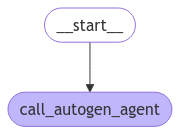

In [ ]:
request = "1. It should support weight loss, muscle gain, health improvement. 2. Integrate with nutritionx api. 3. Should be fact based guidelines from accredited sources, also consider individual dietary restrictions and preferences. 4. Coach should be allowed to share documents answering a set of questions, which can be fed to a vector store and fetched via RAG. 5. Web"
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": request}]}, config, subgraphs=True
    )
)

In [41]:
request = "Plan looks good, please execute and provide code for this"
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": request}]}, config, subgraphs=True
    )
)

Namespace '('researcher_agent:0aff52d1-71f4-fd57-05ce-67b32e793037',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: researcher_agent

To implement the nutritional LLM agent as per the outlined plan, I will provide a structured code example that covers the key components. This will include setting up the environment, integrating with the NutritionX API, managing user profiles, and implementing memory management. 

### Step 1: Set Up the Environment

First, ensure you have the necessary packages installed. You can do this using pip:

```bash
pip install langgraph langchain requests
```

### Step 2: Integrate with NutritionX API

Create a function to interact with the NutritionX API for calorie logging.

```python
import requests

NUTRITIONX_API_URL = "https://api.nutritionx.com/v1/food"  # Example URL, replace with actual endpoint
API_KEY = "your_nutritionx_api_key"  # Replace with your actual API key

def log_meal(meal_n

### Traces 

Example planning trace - 

https://smith.langchain.com/public/7a428dfc-b8b8-4e28-bc05-9508a848082c/r

Example researcher trace - 

https://smith.langchain.com/public/1c9d0e28-56c4-4241-922b-afd614464edd/r

### Test Code 

In [39]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict


# Define state schema for our joke generator
class State(TypedDict):
    topic: str  # The topic provided by the user
    joke: str  # The generated joke
    has_punchline: bool  # Whether the joke has a punchline


# Create the nodes for our graph
def generate_joke(state: State):
    """Generate a joke with a punchline based on the provided topic."""
    # Initialize the LLM
    llm = ChatOpenAI(model="gpt-3.5-turbo")

    # Create a prompt that explicitly asks for a setup followed by a punchline
    prompt = f"Create a joke about {state['topic']}. Format it with a setup followed by 'punchline:' and then the actual punchline."

    # Generate the joke
    response = llm.invoke([HumanMessage(content=prompt)])

    # Return the joke
    return {"joke": response.content}


def check_punchline(state: State):
    """Check if the joke contains the word 'punchline'."""
    # Check if the joke contains the word 'punchline'
    if "punchline" in state["joke"].lower():
        return {"has_punchline": True}
    else:
        return {"has_punchline": False}


# Define conditional edge decision function
def decide_next_step(state: State):
    """Decide whether to end the process."""
    if state["has_punchline"]:
        return "end"
    else:
        # If we were to handle cases without punchlines, we'd route to a fix node
        # But per requirements, we'll just end without feedback
        return "end"


# Build the graph
def build_graph():
    # Create a graph with the defined state schema
    graph = StateGraph(State)

    # Add nodes
    graph.add_node("generate_joke", generate_joke)
    graph.add_node("check_punchline", check_punchline)

    # Add edges
    graph.add_edge(START, "generate_joke")
    graph.add_edge("generate_joke", "check_punchline")
    graph.add_conditional_edges("check_punchline", decide_next_step, {"end": END})

    # Compile the graph
    return graph.compile()


joke_graph = build_graph()

# Invoke the graph with the provided topic
result = joke_graph.invoke({"topic": "cats"})

In [40]:
result

{'topic': 'cats',
 'joke': 'Why was the cat sitting on the computer?\n\nPunchline: It wanted to keep an eye on the mouse!',
 'has_punchline': True}